#INSTALACI√ìN DE DEPENDENCIAS

In [ ]:
!pip install -U datasets
!pip install evaluate rouge_score

#EVALUACIONES

In [10]:
import torch
from transformers import (AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, AutoModelForCausalLM,
                          AutoTokenizer, Trainer, TrainingArguments, pipeline)
from datasets import load_dataset
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from scipy.stats import entropy


##EVALUACI√ìN DE GENERACI√ìN DE TEXTO

Evaluaci√≥n de Generaci√≥n de Texto


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
<ipython-input-11-3180365650>:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrica, y=datos_metricas, hue=None, legend=False, palette="Reds")


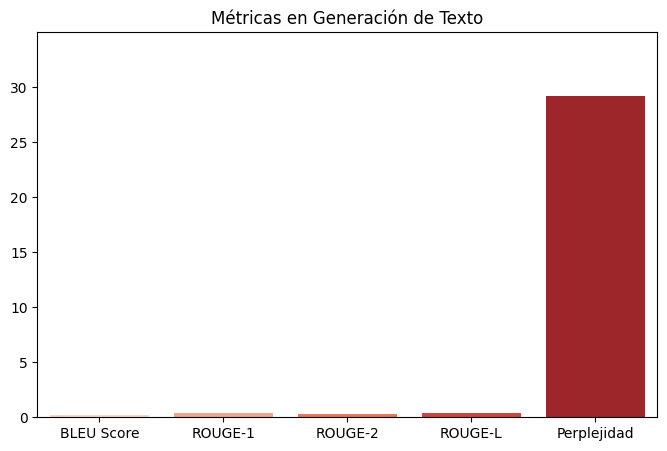


 **Evaluaci√≥n de Texto Generado**
 **Texto generado:** Hab√≠a una vez un reino muy lejano donde la se√±ora que se podr√≠a una sera, se han que lejano leje una hab√≠a con la se√±ora
 **BLEU Score:** 0.16
 **ROUGE-1 F1:** 0.40
 **ROUGE-2 F1:** 0.28
 **ROUGE-L F1:** 0.40
 **Perplejidad:** 29.14


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Cargar modelo GPT-2 y tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model_gen = AutoModelForCausalLM.from_pretrained("gpt2")

# Configurar padding token para evitar advertencias
tokenizer.pad_token = tokenizer.eos_token

# Texto inicial
prompt = "Hab√≠a una vez un reino muy lejano donde"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)

# Generar texto con el modelo
generated_output = model_gen.generate(
    inputs["input_ids"],
    attention_mask=inputs["attention_mask"],  # Agregar atenci√≥n a los tokens v√°lidos
    max_length=50,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id,  # Evita advertencias de Hugging Face
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.7
)

generated_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)

# Referencia para evaluaci√≥n
reference = ["Hab√≠a una vez un reino lejano donde los dragones proteg√≠an a los habitantes."]
candidate = generated_text.split()

# ----------------------------
# Evaluaci√≥n BLEU
# ----------------------------
smoothing = SmoothingFunction().method1
bleu_score = sentence_bleu([ref.split() for ref in reference], candidate, smoothing_function=smoothing)

# ----------------------------
# Evaluaci√≥n ROUGE
# ----------------------------
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
rouge_scores = scorer.score(reference[0], generated_text)

# ----------------------------
# Evaluaci√≥n de Perplejidad (Correcci√≥n)
# ----------------------------

def calcular_perplejidad(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True)["input_ids"]

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss  # Obtiene la loss del modelo (log likelihood negativa)

    perplexity = torch.exp(loss)  # Perplejidad = exp(loss)
    return perplexity.item()

perplexity = calcular_perplejidad(model_gen, tokenizer, generated_text)

# ----------------------------
# Visualizaci√≥n de m√©tricas
# ----------------------------

datos_metricas = [
    bleu_score,
    rouge_scores['rouge1'].fmeasure,
    rouge_scores['rouge2'].fmeasure,
    rouge_scores['rougeL'].fmeasure,
    perplexity
]

metrica = ["BLEU Score", "ROUGE-1", "ROUGE-2", "ROUGE-L", "Perplejidad"]

plt.figure(figsize=(8,5))
sns.barplot(x=metrica, y=datos_metricas, hue=None, legend=False, palette="Reds")
plt.ylim(0, max(datos_metricas) * 1.2)
plt.title("M√©tricas en Generaci√≥n de Texto")
plt.show()

# ----------------------------
# Imprimir Resultados
# ----------------------------

print("\n **Evaluaci√≥n de Texto Generado**")
print(f" **Texto generado:** {generated_text}")
print(f" **BLEU Score:** {bleu_score:.2f}")
print(f" **ROUGE-1 F1:** {rouge_scores['rouge1'].fmeasure:.2f}")
print(f" **ROUGE-2 F1:** {rouge_scores['rouge2'].fmeasure:.2f}")
print(f" **ROUGE-L F1:** {rouge_scores['rougeL'].fmeasure:.2f}")
print(f" **Perplejidad:** {perplexity:.2f}")


* BLEU: Similitud entre texto generado y referencia (coincidencia de n-gramas)
* ROUGE 1: Cu√°ntas palabras de la respuesta est√°n en
la referencia.
* ROUGE 2: Cu√°ntos pares de palabras de la respuesta aparecen en la referencia.
* ROUGE L: Eval√∫a la mayor subsecuencia de palabras en orden entre la referencia y la respuesta.
* Perplejidad: Eval√∫a si un modelo de lenguaje predice bien un texto. Un valor bajo (cercano a 1) indica que el modelo predice mejor el siguiente token. Usa probabilidades asignadas por el modelo a cada palabra.



In [12]:
perplexity = calcular_perplejidad(model_gen, tokenizer, "Dog runs in the park")
print("Perplejidad:", perplexity)

Perplejidad: 141.03565979003906


In [13]:
perplexity = calcular_perplejidad(model_gen, tokenizer, "Dog flies in the almond")
print("Perplejidad:", perplexity)

Perplejidad: 1328.857421875


##EVALUACI√ìN DE CLASIFICACI√ìN

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
import evaluate
import torch
from tqdm import tqdm

# Usar modelo fine-tuned en clasificaci√≥n
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()

# Dataset sin tocar a√∫n
dataset = load_dataset("stanfordnlp/imdb", split="test[:1000]")  # usar una muestra

# M√©tricas
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

# Predicci√≥n directa sin map ni eliminar campos
all_predictions = []
all_labels = []

for example in tqdm(dataset):
    inputs = tokenizer(example["text"], return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    all_predictions.append(pred)
    all_labels.append(example["label"])

# M√©tricas
results = {
    "accuracy": accuracy.compute(predictions=all_predictions, references=all_labels)["accuracy"],
    "precision": precision.compute(predictions=all_predictions, references=all_labels, average="weighted")["precision"],
    "recall": recall.compute(predictions=all_predictions, references=all_labels, average="weighted")["recall"],
    "f1": f1.compute(predictions=all_predictions, references=all_labels, average="weighted")["f1"],
}

print("Resultados:", results)


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1000/1000 [01:15<00:00, 13.32it/s]

Resultados: {'accuracy': 0.85, 'precision': 1.0, 'recall': 0.85, 'f1': 0.918918918918919}



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-38-894704389>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="Blues")


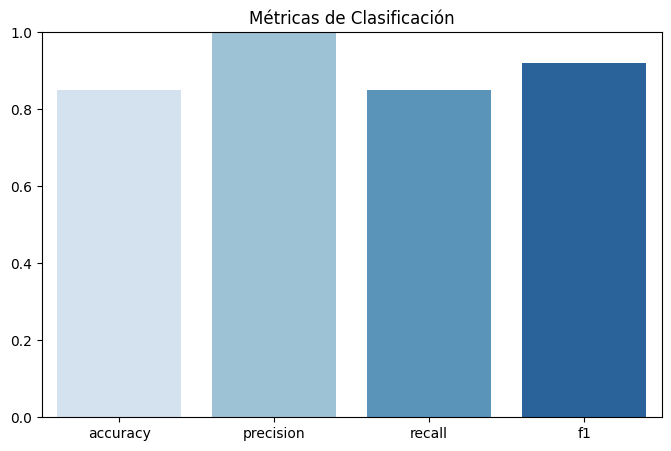

In [38]:
# Visualizaci√≥n de resultados
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="Blues")
plt.ylim(0, 1)
plt.title("M√©tricas de Clasificaci√≥n")
plt.show()

##EVALUACI√ìN DE TRADUCTOR

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")



--- Evaluaci√≥n de Traducci√≥n ---

 **Oraci√≥n 1**
    Oraci√≥n original: Hello, how are you?
    Referencia humana: hola c√≥mo est√°s
    Traducci√≥n del modelo: hola c√≥mo est√°s
    **BLEU Score**: 1.00
    **METEOR Score**: 0.98
    **ROUGE-1 F1**: 1.00
    **ROUGE-L F1**: 1.00
------------------------------------------------------------
 **Oraci√≥n 2**
    Oraci√≥n original: This is an example sentence.
    Referencia humana: esta es una oraci√≥n de ejemplo
    Traducci√≥n del modelo: esta es una frase de ejemplo
    **BLEU Score**: 0.25
    **METEOR Score**: 0.81
    **ROUGE-1 F1**: 0.77
    **ROUGE-L F1**: 0.77
------------------------------------------------------------
 **Oraci√≥n 3**
    Oraci√≥n original: I love machine learning.
    Referencia humana: me encanta el aprendizaje autom√°tico
    Traducci√≥n del modelo: me encanta el aprendizaje autom√°tico
    **BLEU Score**: 1.00
    **METEOR Score**: 1.00
    **ROUGE-1 F1**: 1.00
    **ROUGE-L F1**: 1.00
------------------

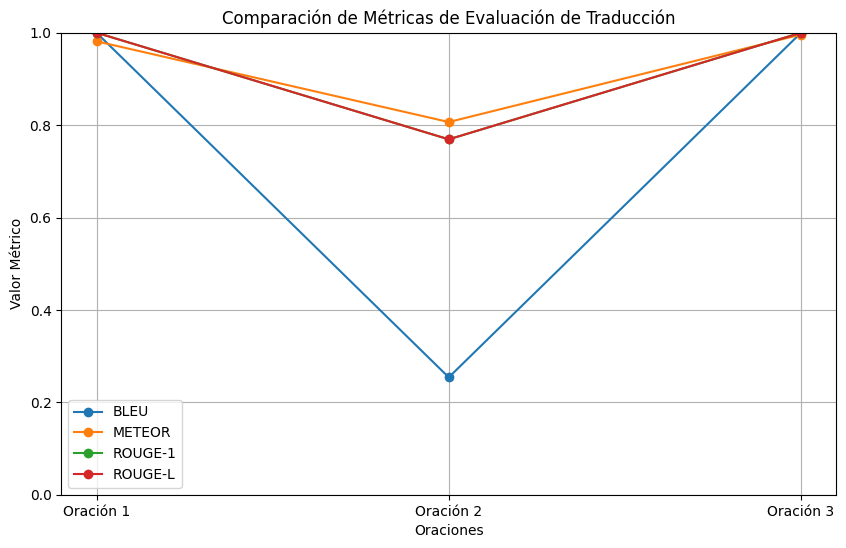

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import MarianMTModel, MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import re
import nltk
nltk.download('wordnet')

# Funci√≥n para limpiar y tokenizar texto
def limpiar_texto(texto):
    texto = texto.lower().strip()  # Convertir a min√∫sculas y quitar espacios
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar puntuaci√≥n
    return texto.split()  # Tokenizar

# Funci√≥n para cargar el modelo y tokenizer
def cargar_modelo(idioma_origen="en", idioma_destino="es"):
    modelo_nombre = f"Helsinki-NLP/opus-mt-{idioma_origen}-{idioma_destino}"
    tokenizer = MarianTokenizer.from_pretrained(modelo_nombre)
    modelo = MarianMTModel.from_pretrained(modelo_nombre)
    return modelo, tokenizer

# Funci√≥n para traducir oraciones
def traducir(modelo, tokenizer, oraciones):
    inputs = tokenizer(oraciones, return_tensors="pt", padding=True, truncation=True)
    traducciones = modelo.generate(**inputs)
    textos_traducidos = [tokenizer.decode(t, skip_special_tokens=True) for t in traducciones]
    return textos_traducidos

# Funci√≥n para evaluar BLEU, METEOR y ROUGE
def evaluar_traduccion(oraciones_originales, traducciones_referencia, idioma_origen="en", idioma_destino="es"):
    modelo, tokenizer = cargar_modelo(idioma_origen, idioma_destino)
    traducciones_generadas = traducir(modelo, tokenizer, oraciones_originales)

    print("\n--- Evaluaci√≥n de Traducci√≥n ---\n")

    # Smoothing para BLEU
    smoothing = SmoothingFunction().method1

    # Instancia para ROUGE
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    metricas_totales = []

    for i in range(len(oraciones_originales)):
        # Preprocesamiento: convertir a min√∫sculas, eliminar puntuaci√≥n y tokenizar
        referencia = limpiar_texto(traducciones_referencia[i])
        traduccion = limpiar_texto(traducciones_generadas[i])

        # BLEU Score (adaptado para frases cortas)
        if len(traduccion) < 4:
            bleu = sentence_bleu([referencia], traduccion, weights=(1.0, 0, 0, 0), smoothing_function=smoothing)  # Solo unigramas
        else:
            bleu = sentence_bleu([referencia], traduccion, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

        # METEOR Score
        meteor = meteor_score([referencia], traduccion)

        # ROUGE Score
        rouge_scores = rouge.score(" ".join(referencia), " ".join(traduccion))
        rouge_1 = rouge_scores["rouge1"].fmeasure
        rouge_l = rouge_scores["rougeL"].fmeasure

        # Guardar m√©tricas para la gr√°fica
        metricas_totales.append({
            "Oraci√≥n": f"Oraci√≥n {i+1}",
            "BLEU": bleu,
            "METEOR": meteor,
            "ROUGE-1": rouge_1,
            "ROUGE-L": rouge_l
        })

        # Mostrar resultados
        print(f" **Oraci√≥n {i+1}**")
        print(f"    Oraci√≥n original: {oraciones_originales[i]}")
        print(f"    Referencia humana: {' '.join(referencia)}")
        print(f"    Traducci√≥n del modelo: {' '.join(traduccion)}")
        print(f"    **BLEU Score**: {bleu:.2f}")
        print(f"    **METEOR Score**: {meteor:.2f}")
        print(f"    **ROUGE-1 F1**: {rouge_1:.2f}")
        print(f"    **ROUGE-L F1**: {rouge_l:.2f}")
        print("-" * 60)

    # -------------------
    # Visualizaci√≥n de m√©tricas con gr√°fico de l√≠neas
    # -------------------
    plt.figure(figsize=(10, 6))

    for metrica in ["BLEU", "METEOR", "ROUGE-1", "ROUGE-L"]:
        valores = [m[metrica] for m in metricas_totales]
        plt.plot([m["Oraci√≥n"] for m in metricas_totales], valores, marker='o', label=metrica)

    plt.ylim(0, 1)
    plt.xlabel("Oraciones")
    plt.ylabel("Valor M√©trico")
    plt.title("Comparaci√≥n de M√©tricas de Evaluaci√≥n de Traducci√≥n")
    plt.legend()
    plt.grid()
    plt.show()

# Datos de prueba
oraciones_originales = [
    "Hello, how are you?",
    "This is an example sentence.",
    "I love machine learning."
]

traducciones_referencia = [
    "Hola, ¬øc√≥mo est√°s?",
    "Esta es una oraci√≥n de ejemplo.",
    "Me encanta el aprendizaje autom√°tico."
]

# Evaluar el modelo
evaluar_traduccion(oraciones_originales, traducciones_referencia, idioma_origen="en", idioma_destino="es")


##EVALUACI√ìN DE QA

In [40]:
import torch
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
import seaborn as sns

Evaluaci√≥n de Recuperaci√≥n de Informaci√≥n


config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Respuesta generada: fue realizado por Alexander Fleming
Exact Match Score: 0
Precision: 0.4
Recall: 1.0
F1 Score: 0.5714285714285715
Exactitud Sem√°ntica: 0.5735858678817749
Exactitud de Contexto: 0.6794387102127075


<ipython-input-41-3117183306>:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metricas, y=valores, palette="Blues")


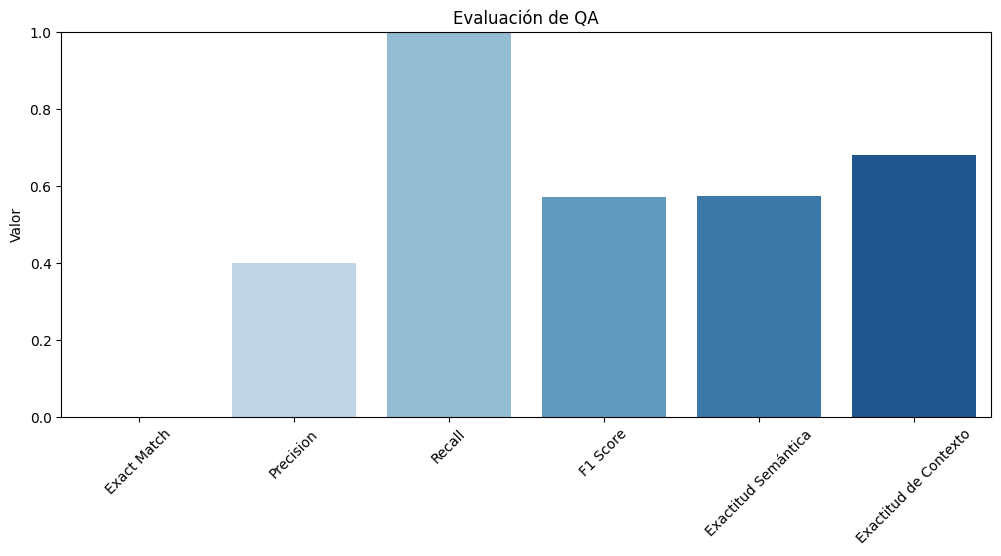

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util

# ----------------------------
# Evaluaci√≥n de Recuperaci√≥n de Informaci√≥n (QA)
# ----------------------------
print("Evaluaci√≥n de Recuperaci√≥n de Informaci√≥n")

# Cargar modelo de Pregunta-Respuesta
retrieval_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

# Contexto y pregunta
contexto = "El descubrimiento de la penicilina fue realizado por Alexander Fleming en 1928."
pregunta = "¬øQui√©n realiz√≥ el descubrimiento de la penicilina?"
resultado = retrieval_pipeline(question=pregunta, context=contexto)

# Respuesta correcta esperada
respuesta_correcta = "Alexander Fleming"

# Normalizaci√≥n de respuestas
respuesta_generada = resultado["answer"].lower()
respuesta_correcta = respuesta_correcta.lower()

# -------------------------------
# Evaluaci√≥n con m√©tricas de QA
# -------------------------------

# Exact Match (EM)
em_score = 1 if respuesta_generada == respuesta_correcta else 0

# C√°lculo de Precision, Recall y F1 Score
tokens_respuesta_generada = set(respuesta_generada.split())
tokens_respuesta_correcta = set(respuesta_correcta.split())

precision = len(tokens_respuesta_generada & tokens_respuesta_correcta) / len(tokens_respuesta_generada) if tokens_respuesta_generada else 0  #palabras correctas generadas/palabras generadas
recall = len(tokens_respuesta_generada & tokens_respuesta_correcta) / len(tokens_respuesta_correcta) if tokens_respuesta_correcta else 0  #palabras correctas generadas/palabras esperadas
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# -------------------------------
# Evaluaci√≥n de Exactitud Sem√°ntica y Contextual
# -------------------------------

# Cargar modelo de embeddings de SentenceTransformers
modelo_emb = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Embeddings de la respuesta generada y la referencia
embedding_generada = modelo_emb.encode(respuesta_generada, convert_to_tensor=True)
embedding_correcta = modelo_emb.encode(respuesta_correcta, convert_to_tensor=True)
embedding_contexto = modelo_emb.encode(contexto, convert_to_tensor=True)

# Exactitud Sem√°ntica ‚Üí Similaridad de embeddings entre la respuesta generada y la correcta
exactitud_semantica = util.pytorch_cos_sim(embedding_generada, embedding_correcta).item()

# Exactitud de Contexto ‚Üí Similaridad de embeddings entre la respuesta generada y el contexto
exactitud_contexto = util.pytorch_cos_sim(embedding_generada, embedding_contexto).item()

# -------------------------------
# Imprimir resultados
# -------------------------------
print("Respuesta generada:", resultado["answer"])
print("Exact Match Score:", em_score)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Exactitud Sem√°ntica:", exactitud_semantica)
print("Exactitud de Contexto:", exactitud_contexto)

# ----------------------------
# Visualizaci√≥n de m√©tricas de QA
# ----------------------------
metricas = ["Exact Match", "Precision", "Recall", "F1 Score", "Exactitud Sem√°ntica", "Exactitud de Contexto"]
valores = [em_score, precision, recall, f1_score, exactitud_semantica, exactitud_contexto]

plt.figure(figsize=(12, 5))
sns.barplot(x=metricas, y=valores, palette="Blues")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.title("Evaluaci√≥n de QA")
plt.ylabel("Valor")
plt.show()


##EVALUACI√ìN DE RECONOCIMIENTO DE VOZ

In [ ]:
pip install speechrecognition jiwer matplotlib seaborn


--- Evaluaci√≥n de Reconocimiento de Voz (STT) ---

 **Transcripci√≥n del modelo:** hola c√≥mo est√°s
**Referencia humana:** Hola, c√≥mo est√°s
**WER (Word Error Rate):** 0.33
**CER (Character Error Rate):** 0.06
------------------------------------------------------------


<ipython-input-43-4180367146>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metricas, y=valores, palette="Reds")


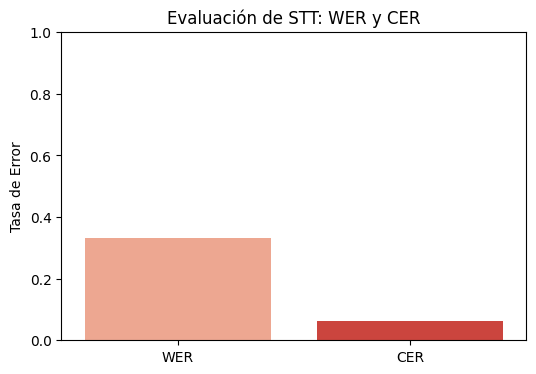

In [43]:
import speech_recognition as sr
import jiwer
import matplotlib.pyplot as plt
import seaborn as sns

# Funci√≥n para reconocer el audio con SpeechRecognition
def reconocer_audio(archivo_audio):
    recognizer = sr.Recognizer()
    with sr.AudioFile(archivo_audio) as source:
        audio = recognizer.record(source)  # Leer todo el audio
    try:
        transcripcion = recognizer.recognize_google(audio, language="es-ES")  # Cambiar idioma si es necesario
        return transcripcion.lower()
    except sr.UnknownValueError:
        return "No se pudo transcribir el audio"
    except sr.RequestError:
        return "Error en la solicitud al servicio de reconocimiento"

# Funci√≥n para calcular WER y CER
def calcular_wer_cer(transcripcion_modelo, referencia_humana):
    # Convertir a min√∫sculas y eliminar espacios innecesarios
    referencia_humana = referencia_humana.lower().strip()
    transcripcion_modelo = transcripcion_modelo.lower().strip()

    # Calcular WER (Tasa de Error de Palabras)
    wer = jiwer.wer(referencia_humana, transcripcion_modelo)

    # Calcular CER (Tasa de Error de Caracteres)
    cer = jiwer.cer(referencia_humana, transcripcion_modelo)

    return wer, cer

# Funci√≥n principal para evaluar STT
def evaluar_stt(archivo_audio, referencia_humana):
    print("\n--- Evaluaci√≥n de Reconocimiento de Voz (STT) ---\n")

    # Obtener la transcripci√≥n del modelo
    transcripcion_modelo = reconocer_audio(archivo_audio)

    # Calcular m√©tricas WER y CER
    wer, cer = calcular_wer_cer(transcripcion_modelo, referencia_humana)

    # Mostrar resultados
    print(f" **Transcripci√≥n del modelo:** {transcripcion_modelo}")
    print(f"**Referencia humana:** {referencia_humana}")
    print(f"**WER (Word Error Rate):** {wer:.2f}")
    print(f"**CER (Character Error Rate):** {cer:.2f}")
    print("-" * 60)

    # Visualizaci√≥n de m√©tricas
    metricas = ["WER", "CER"]
    valores = [wer, cer]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=metricas, y=valores, palette="Reds")
    plt.ylim(0, 1)
    plt.title("Evaluaci√≥n de STT: WER y CER")
    plt.ylabel("Tasa de Error")
    plt.show()

# üîπ Prueba con un archivo de audio
archivo_audio = "audio_prueba.wav"  #
referencia_humana = "Hola, c√≥mo est√°s"  #

# Evaluar STT con WER y CER
evaluar_stt(archivo_audio, referencia_humana)


##EVALUACI√ìN DE RECUPERACI√ìN DE INFORMACI√ìN



In [ ]:
!pip install wikipedia

üîç Buscando 'Machine Learning' en Wikipedia...


 **Evaluaci√≥n en K=1**
 **Precision@1:** 1.00
 **Recall@1:** 0.20
 **NDCG@1:** 0.00

 **Evaluaci√≥n en K=3**
 **Precision@3:** 0.33
 **Recall@3:** 0.20
 **NDCG@3:** 1.00

 **Evaluaci√≥n en K=5**
 **Precision@5:** 0.20
 **Recall@5:** 0.20
 **NDCG@5:** 0.93

 **Evaluaci√≥n en K=10**
 **Precision@10:** 0.30
 **Recall@10:** 0.60
 **NDCG@10:** 0.66


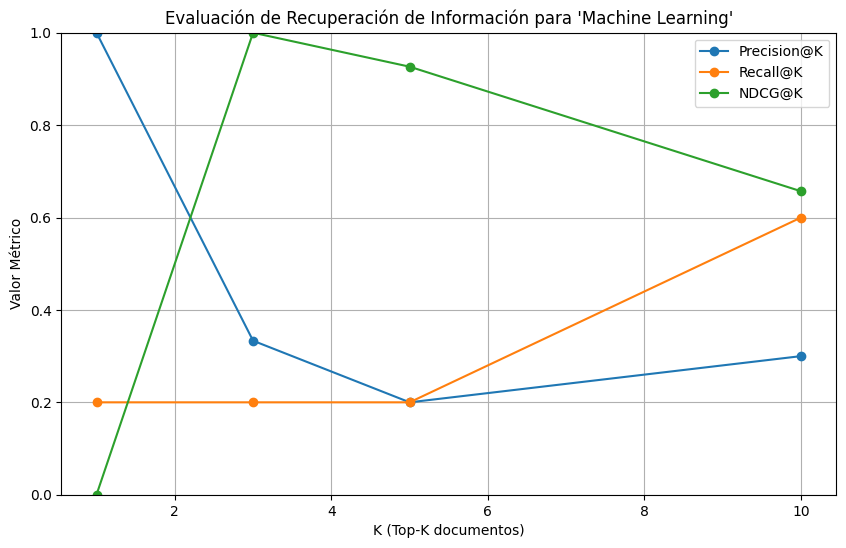

In [45]:
import wikipedia
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score

# ----------------------------
# B√∫squeda en Wikipedia para obtener documentos recuperados
# ----------------------------

consulta = "Machine Learning"  # Consulta real
k_max = 10  # N√∫mero m√°ximo de documentos a recuperar

print(f" Buscando '{consulta}' en Wikipedia...\n")
documentos_recuperados = wikipedia.search(consulta, results=k_max)  # Realizar b√∫squeda en Wikipedia

# Lista de documentos relevantes (definidos manualmente)
documentos_relevantes = {
    "Machine learning",
    "Artificial intelligence",
    "Deep learning",
    "Neural network",
    "Data science"
}  # Simulaci√≥n de art√≠culos clave sobre el tema

# Asignaci√≥n de relevancia (1 si es relevante, 0 si no)
relevancias = [1 if doc in documentos_relevantes else 0 for doc in documentos_recuperados]

# ----------------------------
# Funciones para Evaluaci√≥n de Recuperaci√≥n de Informaci√≥n
# ----------------------------

# Precision@K
def precision_at_k(relevancias, k):
    return sum(relevancias[:k]) / k

# Recall@K
def recall_at_k(relevancias, k, total_relevantes):
    return sum(relevancias[:k]) / total_relevantes

# Normalized Discounted Cumulative Gain (NDCG@K)
def calcular_ndcg(relevancias, k):
    if k <= 1:  # Evitar error en NDCG cuando K=1
        return 0.0
    relevancias_array = np.array([relevancias[:k]])  # Matriz
    ideal_relevancias = sorted(relevancias, reverse=True)[:k]  # Orden ideal para comparar
    ideal_relevancias_array = np.array([ideal_relevancias])  # Matriz
    return ndcg_score(ideal_relevancias_array, relevancias_array)

# ----------------------------
# Evaluaci√≥n en Diferentes Niveles de K
# ----------------------------

ks = [1, 3, 5, 10]  # Diferentes niveles de K para evaluaci√≥n
resultados = {"K": [], "Precision@K": [], "Recall@K": [], "NDCG@K": []}

for k in ks:
    p_at_k = precision_at_k(relevancias, k)
    r_at_k = recall_at_k(relevancias, k, len(documentos_relevantes))
    ndcg_at_k = calcular_ndcg(relevancias, k)

    resultados["K"].append(k)
    resultados["Precision@K"].append(p_at_k)
    resultados["Recall@K"].append(r_at_k)
    resultados["NDCG@K"].append(ndcg_at_k)

    print(f"\n **Evaluaci√≥n en K={k}**")
    print(f" **Precision@{k}:** {p_at_k:.2f}")
    print(f" **Recall@{k}:** {r_at_k:.2f}")
    print(f" **NDCG@{k}:** {ndcg_at_k:.2f}")

# ----------------------------
# Visualizaci√≥n de Resultados
# ----------------------------

plt.figure(figsize=(10, 6))

for metrica in ["Precision@K", "Recall@K", "NDCG@K"]:
    plt.plot(resultados["K"], resultados[metrica], marker='o', label=metrica)

plt.ylim(0, 1)
plt.xlabel("K (Top-K documentos)")
plt.ylabel("Valor M√©trico")
plt.title(f"Evaluaci√≥n de Recuperaci√≥n de Informaci√≥n para '{consulta}'")
plt.legend()
plt.grid()
plt.show()



#AJUSTE

In [61]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Cargar dataset de IMDb
dataset = load_dataset("imdb")

# Cargar modelo y tokenizador preentrenado
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Tokenizaci√≥n
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

dataset = dataset.map(tokenize_function, batched=True)

# Configuraci√≥n del entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"].shuffle().select(range(2000)),  # Subset para prueba r√°pida
    eval_dataset=dataset["test"].shuffle().select(range(500)),
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Evaluaci√≥n inicial del modelo: {'eval_loss': 0.7033364176750183, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 1.74, 'eval_samples_per_second': 287.357, 'eval_steps_per_second': 36.207}


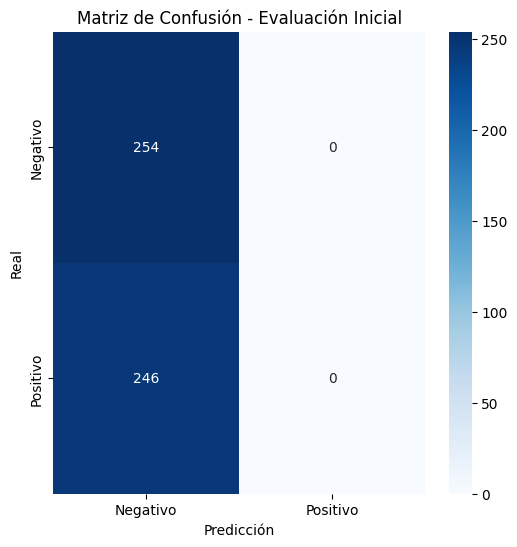

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.51      1.00      0.67       254
           1       0.00      0.00      0.00       246

    accuracy                           0.51       500
   macro avg       0.25      0.50      0.34       500
weighted avg       0.26      0.51      0.34       500

Insufficient data to plot learning curve. Train for more epochs.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [62]:
# Evaluaci√≥n inicial del modelo
eval_result = trainer.evaluate()
print("Evaluaci√≥n inicial del modelo:", eval_result)

# Matriz de confusi√≥n
val_dataset = dataset["test"].shuffle().select(range(500))
y_true = val_dataset["label"]
y_pred  = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n - Evaluaci√≥n Inicial")
plt.show()

# Reporte de clasificaci√≥n
report = classification_report(y_true, y_pred, output_dict=True)
print("Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred))

# Curvas de Aprendizaje
def plot_learning_curve(logs):
    if 'loss' in logs and 'eval_loss' in logs and logs['loss'] and logs['eval_loss']:
        epochs = list(range(1, len(logs['eval_loss']) + 1))

        # Ensure both loss lists have the same length
        train_loss = logs['loss']
        # Repeat the training loss for the first 3 epochs to match eval_loss
        train_loss_extended = [train_loss[0]] * (len(logs['eval_loss']) - len(train_loss)) + train_loss


        plt.figure(figsize=(8, 5))
        plt.plot(epochs, train_loss_extended, label='P√©rdida de Entrenamiento', marker='o')
        plt.plot(epochs, logs['eval_loss'], label='P√©rdida de Validaci√≥n', marker='o')
        plt.xlabel("√âpocas")
        plt.ylabel("P√©rdida")
        plt.title("Curva de Aprendizaje")
        plt.legend()
        plt.show()
    else:
        print("Insufficient data to plot learning curve. Train for more epochs.")

logs = trainer.state.log_history
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
plot_learning_curve({'loss': train_loss, 'eval_loss': eval_loss})



In [63]:
# Entrenamiento del modelo
trainer.train()

TrainOutput(global_step=625, training_loss=0.17784741134643556, metrics={'train_runtime': 121.9204, 'train_samples_per_second': 82.021, 'train_steps_per_second': 5.126, 'total_flos': 331168496640000.0, 'train_loss': 0.17784741134643556, 'epoch': 5.0})

Evaluaci√≥n Intermedia del Modelo: {'eval_loss': 0.8868692517280579, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 1.7165, 'eval_samples_per_second': 291.282, 'eval_steps_per_second': 36.702, 'epoch': 5.0}


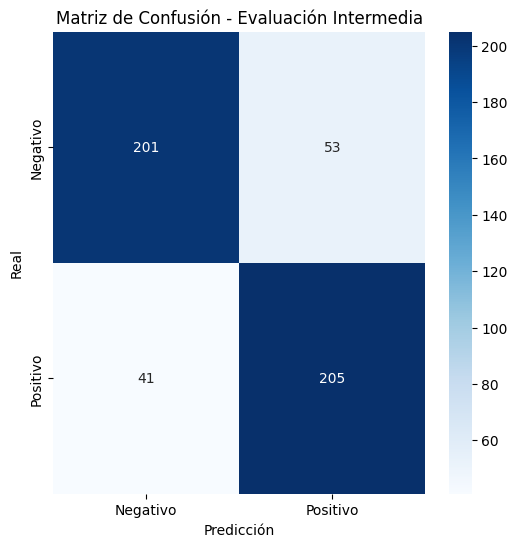

Reporte de Clasificaci√≥n:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       254
           1       0.79      0.83      0.81       246

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.81       500
weighted avg       0.81      0.81      0.81       500



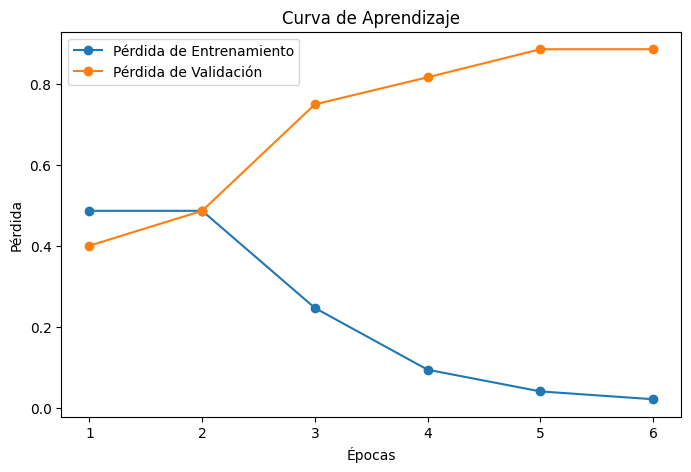

In [64]:
# Segunda Evaluaci√≥n del Modelo
eval_result2 = trainer.evaluate()
print("Evaluaci√≥n Intermedia del Modelo:", eval_result2)

# Matriz de confusi√≥n
y_pred  = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n - Evaluaci√≥n Intermedia")
plt.show()

# Reporte de clasificaci√≥n
report2 = classification_report(y_true, y_pred, output_dict=True)
print("Reporte de Clasificaci√≥n:")
print(classification_report(y_true, y_pred))

logs = trainer.state.log_history
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
plot_learning_curve({'loss': train_loss, 'eval_loss': eval_loss})

‚úî El modelo est√° sobreajustando despu√©s de la cuarta √©poca.

‚úî Se podr√≠a reducir el n√∫mero de √©pocas para evitar el sobreajuste, aunque ya son pocas.

‚úî Aplicar regularizaci√≥n, como Dropout o Weight Decay, podr√≠a mejorar la capacidad de generalizaci√≥n.

‚úî Aumentar el dataset con m√°s ejemplos o con data augmentation ayudar√≠a a mejorar la robustez del modelo.

‚úî Ajustar la tasa de aprendizaje puede ayudar a que el modelo no ajuste demasiado r√°pido a los datos.

In [68]:
# Ajuste de hiperpar√°metros
print("Ajustando hiperpar√°metros...")
training_args.learning_rate = 1e-5  # Reducir tasa de aprendizaje
training_args.weight_decay = 0.2  # Aumentar regularizaci√≥n
training_args.num_train_epochs = 3  # Reducir n√∫mero de √©pocas
trainer.train_dataset = dataset["train"].shuffle().select(range(10000)) #Aumento n¬∫ datos
trainer.train()

Ajustando hiperpar√°metros...


TrainOutput(global_step=1875, training_loss=0.1539801035563151, metrics={'train_runtime': 343.3707, 'train_samples_per_second': 87.369, 'train_steps_per_second': 5.461, 'total_flos': 993505489920000.0, 'train_loss': 0.1539801035563151, 'epoch': 3.0})

Evaluaci√≥n despu√©s del ajuste: {'eval_loss': 0.8232508897781372, 'eval_model_preparation_time': 0.0016, 'eval_runtime': 1.719, 'eval_samples_per_second': 290.874, 'eval_steps_per_second': 36.65, 'epoch': 3.0}


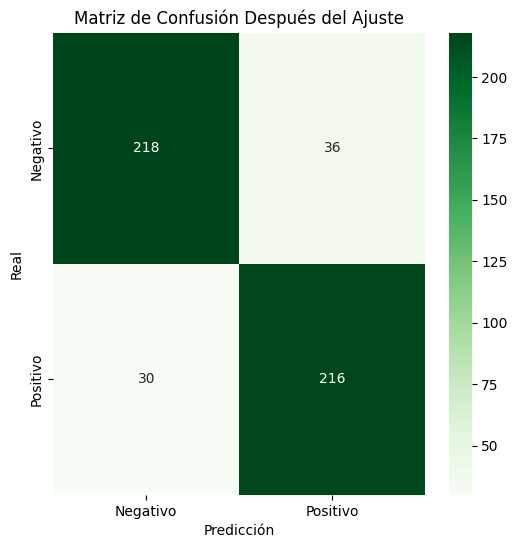

Reporte de Clasificaci√≥n Despu√©s del Ajuste:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       254
           1       0.86      0.88      0.87       246

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



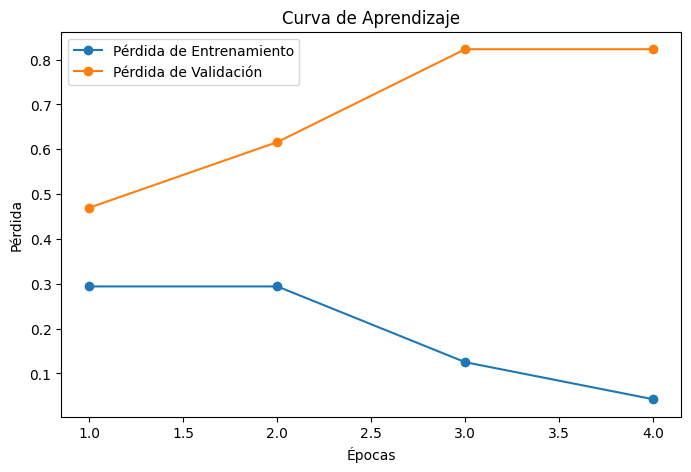

In [69]:
# Evaluaci√≥n despu√©s del ajuste
eval_result_after = trainer.evaluate()
print("Evaluaci√≥n despu√©s del ajuste:", eval_result_after)

# Matriz de confusi√≥n tras ajuste
y_pred_after  = np.argmax(trainer.predict(val_dataset).predictions, axis=1)
cm_after = confusion_matrix(y_true, y_pred_after)

plt.figure(figsize=(6,6))
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Greens", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.title("Matriz de Confusi√≥n Despu√©s del Ajuste")
plt.show()

# Reporte de clasificaci√≥n tras ajuste
report_after = classification_report(y_true, y_pred_after, output_dict=True)
print("Reporte de Clasificaci√≥n Despu√©s del Ajuste:")
print(classification_report(y_true, y_pred_after))

# Curvas de Aprendizaje despu√©s del ajuste
logs_after = trainer.state.log_history
train_loss_after = [entry['loss'] for entry in logs_after if 'loss' in entry]
eval_loss_after = [entry['eval_loss'] for entry in logs_after if 'eval_loss' in entry]
plot_learning_curve({'loss': train_loss_after, 'eval_loss': eval_loss_after})

##Comparaci√≥n de las m√©tricas antes y despu√©s

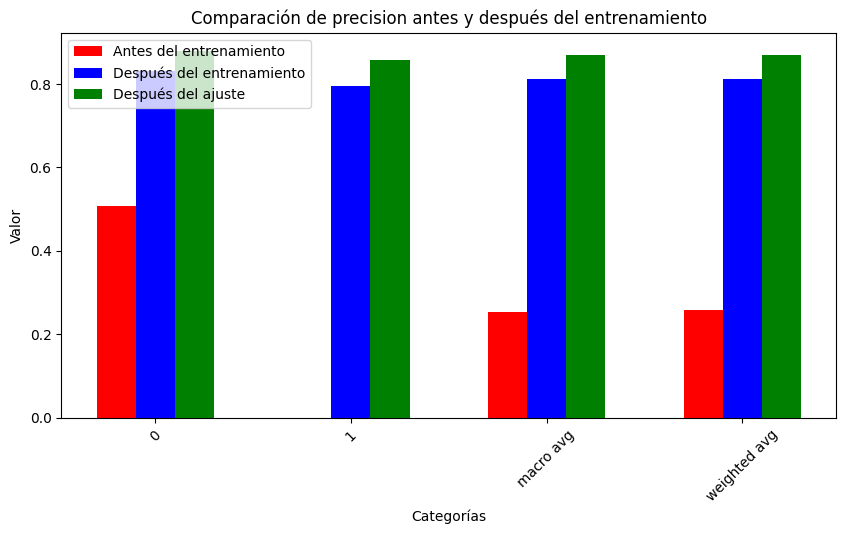

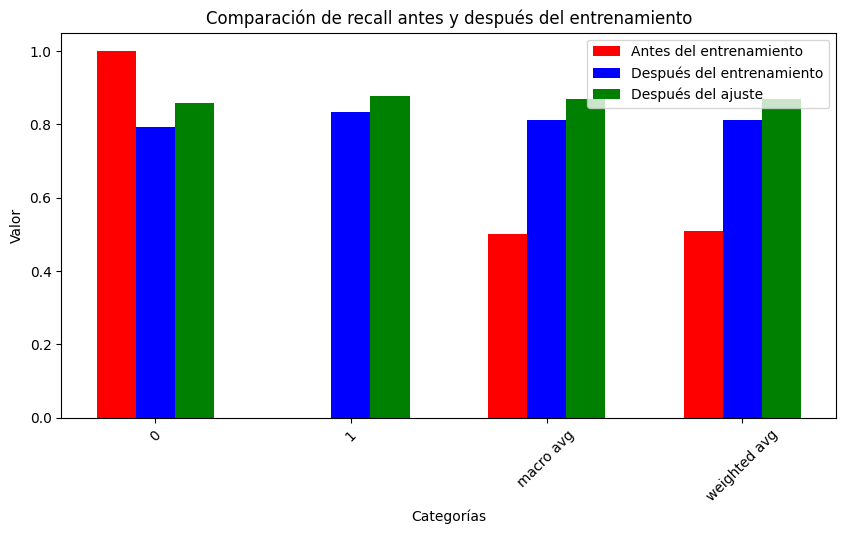

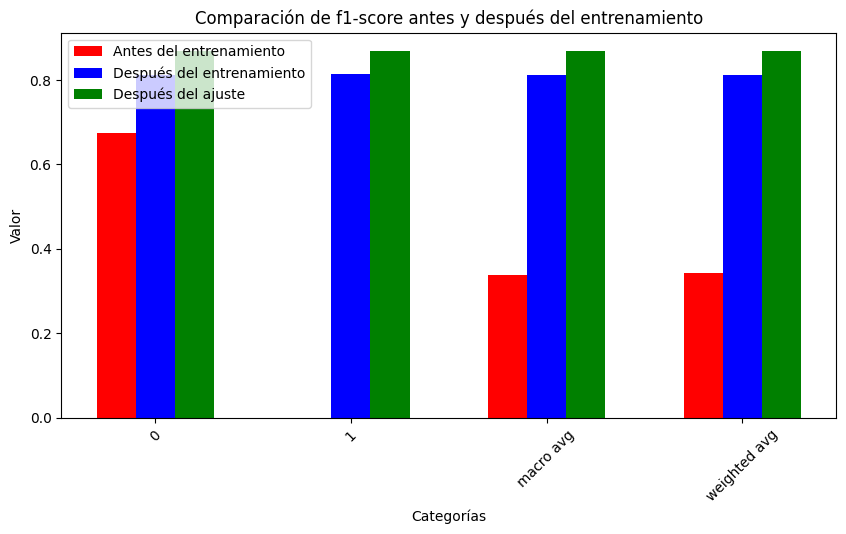

In [70]:
# Comparaci√≥n de m√©tricas antes y despu√©s
def plot_metrics_comparison(report, report2, report_after):
    metrics = ["precision", "recall", "f1-score"]
    categories = ["0", "1", "macro avg", "weighted avg"]
    x = np.arange(len(categories))
    width = 0.2

    for metric in metrics:
        before_values = [report[cat][metric] for cat in categories]
        after_values = [report2[cat][metric] for cat in categories]
        ajuste_values = [report_after[cat][metric] for cat in categories]

        plt.figure(figsize=(10,5))
        plt.bar(x - width, before_values, width, label='Antes del entrenamiento', color='red')
        plt.bar(x, after_values, width, label='Despu√©s del entrenamiento', color='blue')
        plt.bar(x + width, ajuste_values, width, label='Despu√©s del ajuste', color='green')

        plt.xlabel("Categor√≠as")
        plt.ylabel("Valor")
        plt.title(f"Comparaci√≥n de {metric} antes y despu√©s del entrenamiento")
        plt.xticks(ticks=x, labels=categories, rotation=45)
        plt.legend()
        plt.show()

plot_metrics_comparison(report, report2, report_after)

#EVALUACI√ìN DE PROMPTS

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


[TinyLlama] Prompt Correcto: Pregunta: ¬øCu√°l es la capital de Francia?
    Respuesta:
Respuesta generada: Par√≠s
    
    Pregunta: ¬øCu√°l es la capital de Italia?
    Respuesta: Roma
    
    P
Similitud con esperada: 0.56

[TinyLlama] Prompt Incorrecto: Francia capital?
Respuesta generada: 
Similitud con esperada: -0.07

[TinyLlama] Prompt Correcto: Pregunta: Explica la teor√≠a de la relatividad en t√©rminos simples.
    Respuesta:
Respuesta generada: La teor√≠a de la relatividad establece que la velocidad de un objeto en un sistema de coordenadas es
Similitud con esperada: 0.66

[TinyLlama] Prompt Incorrecto: Relatividad teor√≠a, c√≥mo?
Respuesta generada: Por supuesto, la relatividad teor√≠a describe la relaci√≥n entre los objetos en el espacio-tiempo y la velocidad de los objetos en el espa
Similitud con esperada: 0.82

[TinyLlama] Prompt Correcto: Pregunta: Escribe un poema corto sobre la naturaleza.
    Respuesta:
Respuesta generada: Pregunta: ¬øCu√°l es la naturaleza de la 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GPT-2] Prompt Correcto: Pregunta: ¬øCu√°l es la capital de Francia?
    Respuesta:
Respuesta generada: ¬øCu√°l es la capital de Francia?

Pregunta: ¬øCu√°l es la capital
Similitud con esperada: 0.71

[GPT-2] Prompt Incorrecto: Francia capital?
Respuesta generada: It is not clear whether the government will be able to meet its target of reducing the number of asylum seekers arriving in the country.

The government has said it will not allow asylum seekers to leave the country without a
Similitud con esperada: 0.08


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GPT-2] Prompt Correcto: Pregunta: Explica la teor√≠a de la relatividad en t√©rminos simples.
    Respuesta:
Respuesta generada: Pregunta: Explica la teor√≠a de la relatividad en t√©rmin
Similitud con esperada: 0.61

[GPT-2] Prompt Incorrecto: Relatividad teor√≠a, c√≥mo?
Respuesta generada: This is a very important question.

The answer is that the answer is not so much that the answer is not so much that the answer is not so much that the answer
Similitud con esperada: 0.01


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



[GPT-2] Prompt Correcto: Pregunta: Escribe un poema corto sobre la naturaleza.
    Respuesta:
Respuesta generada: Escribe un poema corto sobre la naturaleza.
Similitud con esperada: 0.36

[GPT-2] Prompt Incorrecto: Poema naturaleza, algo?
Respuesta generada: I was born in the year 2000, and I'm the daughter of a former president of the United States. I'm a former president of the United States, and I'm the daughter of
Similitud con esperada: 0.06


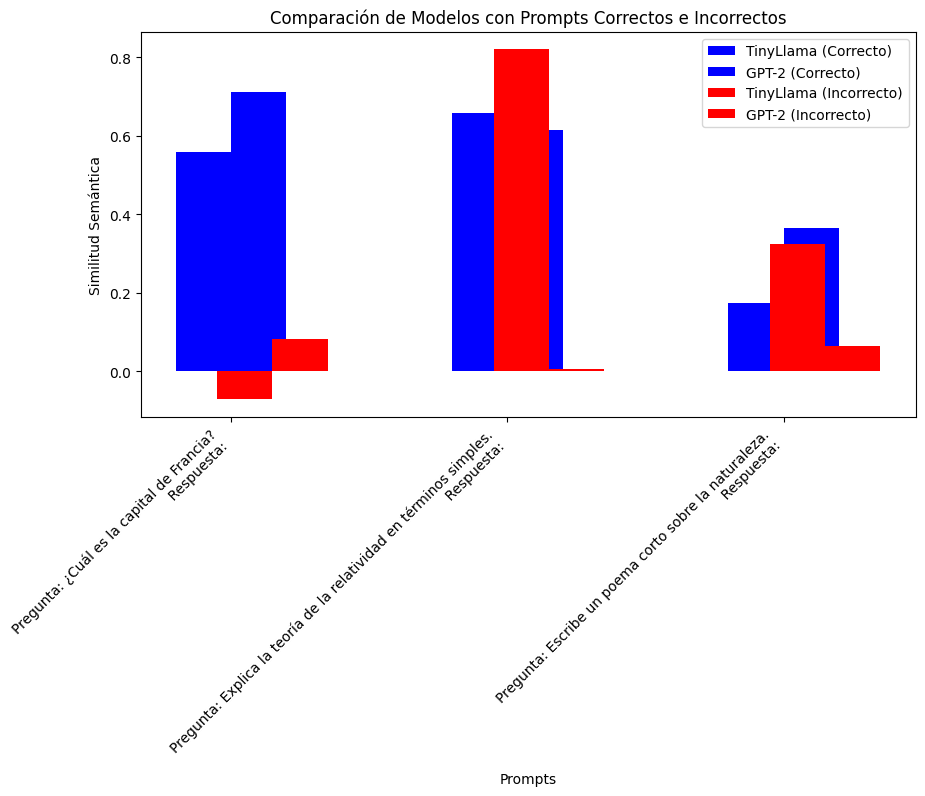

In [53]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np

# Modelos a evaluar
modelos = {
    "TinyLlama": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    "GPT-2": "gpt2",
}

# Prompts correctos e incorrectos a evaluar
prompts_correctos = [
    """Pregunta: ¬øCu√°l es la capital de Francia?
    Respuesta:""",
    """Pregunta: Explica la teor√≠a de la relatividad en t√©rminos simples.
    Respuesta:""",
    """Pregunta: Escribe un poema corto sobre la naturaleza.
    Respuesta:""",
]

prompts_incorrectos = [
    "Francia capital?",
    "Relatividad teor√≠a, c√≥mo?",
    "Poema naturaleza, algo?",
]

# Respuestas esperadas
respuestas_esperadas = [
    "La capital de Francia es Par√≠s.",
    "La teor√≠a de la relatividad fue desarrollada por Einstein y explica c√≥mo el tiempo y el espacio est√°n interrelacionados.",
    "El viento susurra entre los √°rboles, el r√≠o canta su dulce canci√≥n.",
]

# Modelo para calcular similitud sem√°ntica
modelo_embeddings = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

def generar_respuesta(model_name, prompt):
    """Genera una respuesta dada un modelo y un prompt."""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        output = model.generate(**inputs, max_length=50, do_sample="True", temperature=0.3)
    respuesta= tokenizer.decode(output[0], skip_special_tokens=True)
    return respuesta.replace(prompt, "").strip()

def calcular_similitud(texto1, texto2):
    """Calcula la similitud sem√°ntica entre dos textos."""
    emb1 = modelo_embeddings.encode(texto1, convert_to_tensor=True)
    emb2 = modelo_embeddings.encode(texto2, convert_to_tensor=True)
    return util.pytorch_cos_sim(emb1, emb2).item()

def evaluar_prompts():
    """Eval√∫a distintos modelos con prompts correctos e incorrectos y mide similitud sem√°ntica."""
    resultados_correctos = {}
    resultados_incorrectos = {}
    for modelo, modelo_name in modelos.items():
        similitudes_correctas = []
        similitudes_incorrectas = []
        for i, (prompt_correcto, prompt_incorrecto) in enumerate(zip(prompts_correctos, prompts_incorrectos)):
            respuesta_correcta = generar_respuesta(modelo_name, prompt_correcto)
            respuesta_incorrecta = generar_respuesta(modelo_name, prompt_incorrecto)
            similitud_correcta = calcular_similitud(respuesta_correcta, respuestas_esperadas[i])
            similitud_incorrecta = calcular_similitud(respuesta_incorrecta, respuestas_esperadas[i])
            similitudes_correctas.append(similitud_correcta)
            similitudes_incorrectas.append(similitud_incorrecta)
            print(f"\n[{modelo}] Prompt Correcto: {prompt_correcto}")
            print(f"Respuesta generada: {respuesta_correcta}")
            print(f"Similitud con esperada: {similitud_correcta:.2f}")
            print(f"\n[{modelo}] Prompt Incorrecto: {prompt_incorrecto}")
            print(f"Respuesta generada: {respuesta_incorrecta}")
            print(f"Similitud con esperada: {similitud_incorrecta:.2f}")
        resultados_correctos[modelo] = similitudes_correctas
        resultados_incorrectos[modelo] = similitudes_incorrectas
    return resultados_correctos, resultados_incorrectos

# Evaluar modelos con prompts correctos e incorrectos
resultados_correctos, resultados_incorrectos = evaluar_prompts()

# Visualizar comparaci√≥n de prompts correctos e incorrectos
x = np.arange(len(prompts_correctos))
width = 0.2
plt.figure(figsize=(10,5))
for i, (modelo, similitudes) in enumerate(resultados_correctos.items()):
    plt.bar(x + i * width, similitudes, width, label=f"{modelo} (Correcto)", color='blue')
for i, (modelo, similitudes) in enumerate(resultados_incorrectos.items()):
    plt.bar(x + i * width + 0.15, similitudes, width, label=f"{modelo} (Incorrecto)", color='red')

plt.xlabel("Prompts")
plt.ylabel("Similitud Sem√°ntica")
plt.title("Comparaci√≥n de Modelos con Prompts Correctos e Incorrectos")
plt.xticks(ticks=x + width/2, labels=prompts_correctos, rotation=45, ha="right")
plt.legend()
plt.show()
